#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

# Install dependencies:

# Imports

In [1]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [2]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [4]:
output_path = "C:\\Users\\daniel\\uni\\seminar_critical-social-media-analysis\\output\\"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [5]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [6]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [7]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.40080762
n_clusters: 52 silhouette_avg: 0.30833262
n_clusters: 102 silhouette_avg: 0.35291496
n_clusters: 152 silhouette_avg: 0.33425283
n_clusters: 202 silhouette_avg: 0.30821362
n_clusters: 252 silhouette_avg: 0.27814943


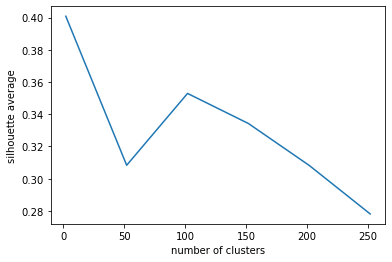

In [8]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=300 
step=50 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [22]:
number_of_clusters =  30
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 29     5
1      5
10     6
20     7
6      8
16     9
28     9
11     9
14     9
4      9
19    12
27    12
15    12
8     12
2     14
26    15
23    16
12    16
18    18
9     19
7     19
3     21
13    22
24    23
22    24
21    25
25    29
17    29
0     38
5     42
Name: label_kmedoids, dtype: int64


In [23]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [24]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

# Visualize clustering results

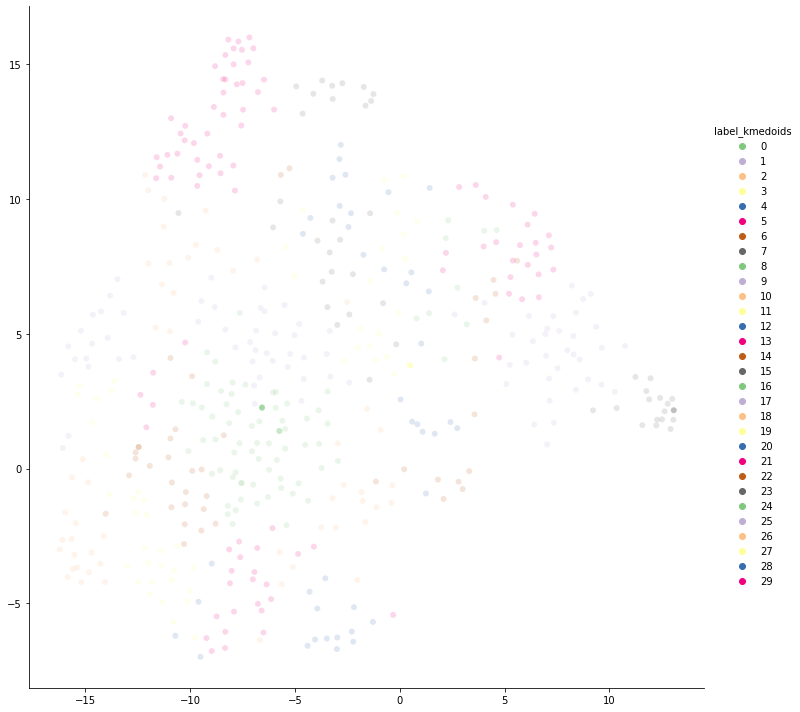

In [25]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

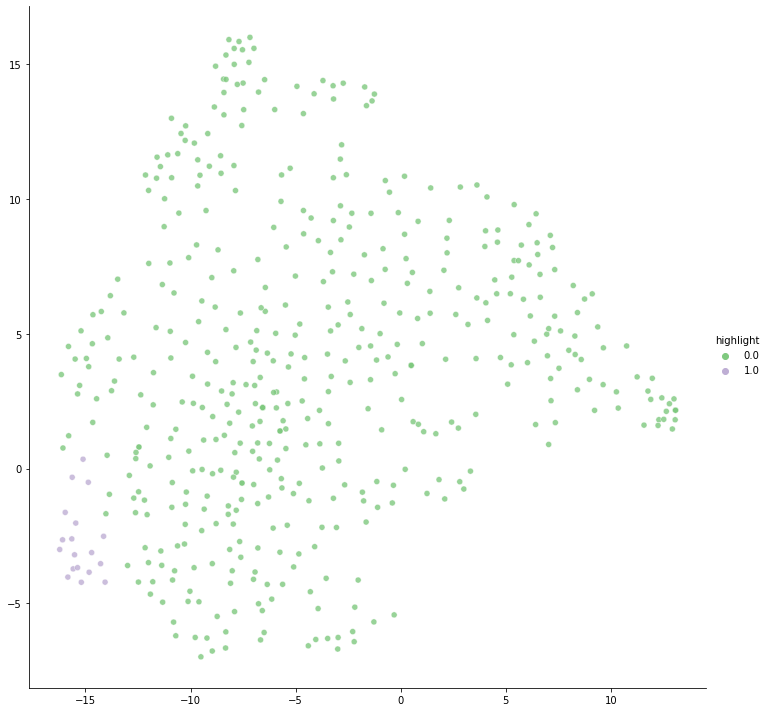

In [26]:
## Choose a cluster to higlight:
cluster_num = 18

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [27]:
# print the medoids 
data.iloc[medoids_indices][:10]

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
161,2019-08-15 11:36:05,Grace G,"Who cares about climate change when the economy is collapsing around us, think great recesion 1939!",0,"Who cares about climate change when the economy is collapsing around us, think\ngreat recesion 1939!\n\n",-1.0,0,0.000000e+00,0.0
105,2019-08-18 21:45:26,Marimilitarybrat,Andrew Phillips. Same thing here in e U.S.,1,. Same thing here in e U.S.\n\n,-1.0,1,5.960464e-08,0.0
307,2019-08-13 20:35:49,Arthur Treibs,"25 million people in Australia are responsible for &quot;climate change&quot; of 7.5 BILLION wold. Tell all those carpet beggars to get ROOTED, guys!",0,"25 million people in Australia are responsible for ""climate change"" of 7.5\nBILLION wold. Tell all those carpet beggars to get ROOTED, guys!\n\n",-1.0,2,2.384186e-07,0.0
117,2019-08-16 01:06:29,Yousif A Tobiya,"I sent thousands of scientific messages to the whole world telling them to stop the melting of ice caps of polars and Himalayas to reduce tsunami, earthquakes, volcanic eruptions, &amp; ,&amp; ,&amp; ..<br />The earth will BE like the planet of Venous...<br />It&#39;s so sad to say the time is over..<br />These studies had completed and sent on 26th July 2000...<br /><br />THE EARTH HAS TILTED 2 DEGREES...<br />THE EARTH HAS A NEW ORBIT,WE MUST FIX IT ON ITS NEW ORBIT...<br />Yousif A Tobiya <br />Forcibly displaced",0,"I sent thousands of scientific messages to the whole world telling them to\nstop the melting of ice caps of polars and Himalayas to reduce tsunami,\nearthquakes, volcanic eruptions, & ,& ,& .. \nThe earth will BE like the planet of Venous... \nIt's so sad to say the time is over.. \nThese studies had completed and sent on 26th July 2000... \n \nTHE EARTH HAS TILTED 2 DEGREES... \nTHE EARTH HAS A NEW ORBIT,WE MUST FIX IT ON ITS NEW ORBIT... \n \nForcibly displaced\n\n",-1.0,3,0.000000e+00,0.0
345,2019-08-13 16:59:50,Bob Dylan,"better to spend the money on free hookers, chosen by lottery.",0,"better to spend the money on free hookers, chosen by lottery.\n\n",-1.0,4,0.000000e+00,0.0
107,2019-08-16 05:12:21,Endless space.,"I f these island nations want Chinese money then let them, they will soo learn that there freedoms are gone and they will be running to Australia and other countries for help.",0,"I f these island nations want Chinese money then let them, they will soo learn\nthat there freedoms are gone and they will be running to Australia and other\ncountries for help.\n\n",-1.0,5,0.000000e+00,0.0
165,2019-08-15 10:59:33,Starlight Sign,‘Ignorance is a choice’ Kevin Blanch,0,‘Ignorance is a choice’ Kevin Blanch\n\n,-1.0,6,0.000000e+00,0.0
439,2019-08-19 03:12:32,Michael Paliden,@Brett B N0,1,@ N0\n\n,-1.0,7,1.788139e-07,0.0
27,2019-08-20 00:51:13,Ken Hardie,"The climate changers are a classic cult. End of the world hysteria, blasphemous deniers, doctrine and dogma their own peculiar religious like language and priest like fire and brimstone spokesman.<br />Always targeting the gullible and naive.",0,"The climate changers are a classic cult. End of the world hysteria,\nblasphemous deniers, doctrine and dogma their own peculiar religious like\nlanguage and priest like fire and brimstone spokesman. \nAlways targeting the gullible and naive.\n\n",-1.0,8,0.000000e+00,0.0
175,2019-08-15 09:37:03,kim weaver,The big lie is that sea levels GLOBALLY are not rising. They ARE rising and rising at an increasing rate. This was pure bullshit. I had hoped Aussies would be more realistic. These idiots are T-Rumpistas.,0,The big lie is that sea levels GLOBALLY are not rising. They ARE rising and\nrising at an increasing rate. This was pure bullshit. I had hoped Aussies\nwould be more realistic. These idiots are T-Rumpistas.\n\n,-1.0,9,2.384186e-07,0.0


In [28]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  38 mean distance from center:  0.004458897819858976 Proportion of replies: 34.21052631578947
1 number of samples:  5 mean distance from center:  0.003802776336669922 Proportion of replies: 80.0
2 number of samples:  14 mean distance from center:  0.006189091072883457 Proportion of replies: 28.571428571428573
3 number of samples:  21 mean distance from center:  0.003914322223863564 Proportion of replies: 42.857142857142854
4 number of samples:  9 mean distance from center:  0.0032232866942649707 Proportion of replies: 55.55555555555556
5 number of samples:  42 mean distance from center:  0.00353895484295208 Proportion of replies: 21.428571428571427
6 number of samples:  8 mean distance from center:  0.0023506581783294678 Proportion of replies: 87.5
7 number of samples:  19 mean distance from center:  0.0011993081898253877 Proportion of replies: 47.36842105263158
8 number of samples:  12 mean distance from center:  0.0040779512346489355 Proportion of replies: 41.666

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [29]:
# Choose a cluster to print
cluster_number = 27
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 12
Average Distance from cluster center: 3.545483e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
260,2019-08-18 21:43:13,Marimilitarybrat,Brent van de Stadt. Our Trump does have a big mouth but he is sharp as a two edged sword.,1,Brent van de Stadt. Our Trump does have a big mouth but he is sharp as a two\nedged sword.\n\n,-1.0,27,0.000000,0.0
259,2019-08-18 21:57:28,Voetsak,Trump my mentor ☝️,1,Trump my mentor ☝️\n\n,-1.0,27,0.000003,0.0
481,2019-08-13 15:09:13,Martin A,"To right well said. they like to criticise trump but he got that right, wise man not a sheep politician.",1,"To right well said. they like to criticise trump but he got that right, wise\nman not a sheep politician.\n\n",-1.0,27,0.000005,0.0
390,2019-08-30 13:13:47,Cyrus Wang,@RO BOT no we don't. Our current politics are very similar to Trump's. You can see that sco mo has nearly stood with trump on nearly all foreign affairs issue. Trump is just a bit louder and a better memer.,1,@ no we don't. Our current politics are very similar to Trump's. You can\nsee that sco mo has nearly stood with trump on nearly all foreign affairs\nissue. Trump is just a bit louder and a better memer.\n\n,-1.0,27,0.000007,0.0
391,2019-08-18 05:13:20,RO BOT,@Allen Dribnenki YES .. INDEED .. WE NEED A LEADER WHO HAS GUT'S .. AN AUSSIE TRUMP TO SAY .. YOU DON'T LIKE IT NWO .. WELL GO FK YOURSELVES .. WE ARE OUT ..MMK,1,@ YES .. INDEED .. WE NEED A LEADER WHO HAS GUT'S .. AN AUSSIE\nTRUMP TO SAY .. YOU DON'T LIKE IT NWO .. WELL GO FK YOURSELVES .. WE ARE OUT\n..MMK\n\n,-1.0,27,0.000019,0.0
387,2019-09-05 12:24:33,Cyrus Wang,@Gavin Coleman debt and deficit speed has slowed a little bit from Obama and nearly every single country in the world has debt. I dont expect trump to address the debt because right now he is focused on taking down China. He is allowing debt for a temporal economic boost to beat China. Hope he wins.,1,@Gavin Coleman debt and deficit speed has slowed a little bit from Obama and\nnearly every single country in the world has debt. I dont expect trump to\naddress the debt because right now he is focused on taking down China. He is\nallowing debt for a temporal economic boost to beat China. Hope he wins.\n\n,-1.0,27,0.000033,0.0
432,2019-08-15 01:29:08,Mark Australia,Peter Weissmann ....lol.... I think he meant Right Wing... nutters.... but you already knew that.... Just like calling circumcision out as male genital mutilation often draws the comments 'oh you are anti semitic',1,....lol.... I think he meant Right Wing... nutters.... but you\nalready knew that.... Just like calling circumcision out as male genital\nmutilation often draws the comments 'oh you are anti semitic'\n\n,-1.0,27,0.000042,0.0
388,2019-09-05 12:20:02,Cyrus Wang,@Gavin Coleman i dont know what you are talking about in your first 4 lines but Trump's election has had nothing to do with Russia. Russia is politically a far left country and you expect him to help a centre right figure in an election? Trump is fucking over Russia's plans in the middle east. Trump has made a shit ton of demands for putin. Not something you expect if russia helped him win. Trump also threatened China and Russia with fat tariffs if they continued supporting the Venezuelan dictator. He threatened Germany with sanctions if they continued getting gas from a pipeline from russia and told germany to spend more on defence in case anything happens with Russia. Not very convincing Putin would want to help someone who would fuck him up.,1,@Gavin Coleman i dont know what you are talking about in your first 4 lines\nbut Trump's election has had nothing to do with Russia. Russia is politically\na far left country and you expect him to help a centre right figure in an\nelection? Trump is fucking over Russia's plans in the middle east. Trump has\nmade a shit ton of demands for putin. Not something you expect if russia\nhelped him win. Trump also threatened China and Russia with fat tariffs if\nthey continued supporting the Venezuelan 

# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [31]:
#which cluster would you like to assign labels to?
cluster_number = 27
#your label
label_manual = 'trump'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [32]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
260,2019-08-18 21:43:13,Marimilitarybrat,Brent van de Stadt. Our Trump does have a big mouth but he is sharp as a two edged sword.,1,Brent van de Stadt. Our Trump does have a big mouth but he is sharp as a two\nedged sword.\n\n,trump,27,0.000000,0.0
259,2019-08-18 21:57:28,Voetsak,Trump my mentor ☝️,1,Trump my mentor ☝️\n\n,trump,27,0.000003,0.0
481,2019-08-13 15:09:13,Martin A,"To right well said. they like to criticise trump but he got that right, wise man not a sheep politician.",1,"To right well said. they like to criticise trump but he got that right, wise\nman not a sheep politician.\n\n",trump,27,0.000005,0.0
390,2019-08-30 13:13:47,Cyrus Wang,@RO BOT no we don't. Our current politics are very similar to Trump's. You can see that sco mo has nearly stood with trump on nearly all foreign affairs issue. Trump is just a bit louder and a better memer.,1,@ no we don't. Our current politics are very similar to Trump's. You can\nsee that sco mo has nearly stood with trump on nearly all foreign affairs\nissue. Trump is just a bit louder and a better memer.\n\n,trump,27,0.000007,0.0
391,2019-08-18 05:13:20,RO BOT,@Allen Dribnenki YES .. INDEED .. WE NEED A LEADER WHO HAS GUT'S .. AN AUSSIE TRUMP TO SAY .. YOU DON'T LIKE IT NWO .. WELL GO FK YOURSELVES .. WE ARE OUT ..MMK,1,@ YES .. INDEED .. WE NEED A LEADER WHO HAS GUT'S .. AN AUSSIE\nTRUMP TO SAY .. YOU DON'T LIKE IT NWO .. WELL GO FK YOURSELVES .. WE ARE OUT\n..MMK\n\n,trump,27,0.000019,0.0
387,2019-09-05 12:24:33,Cyrus Wang,@Gavin Coleman debt and deficit speed has slowed a little bit from Obama and nearly every single country in the world has debt. I dont expect trump to address the debt because right now he is focused on taking down China. He is allowing debt for a temporal economic boost to beat China. Hope he wins.,1,@Gavin Coleman debt and deficit speed has slowed a little bit from Obama and\nnearly every single country in the world has debt. I dont expect trump to\naddress the debt because right now he is focused on taking down China. He is\nallowing debt for a temporal economic boost to beat China. Hope he wins.\n\n,trump,27,0.000033,0.0
432,2019-08-15 01:29:08,Mark Australia,Peter Weissmann ....lol.... I think he meant Right Wing... nutters.... but you already knew that.... Just like calling circumcision out as male genital mutilation often draws the comments 'oh you are anti semitic',1,....lol.... I think he meant Right Wing... nutters.... but you\nalready knew that.... Just like calling circumcision out as male genital\nmutilation often draws the comments 'oh you are anti semitic'\n\n,trump,27,0.000042,0.0
388,2019-09-05 12:20:02,Cyrus Wang,@Gavin Coleman i dont know what you are talking about in your first 4 lines but Trump's election has had nothing to do with Russia. Russia is politically a far left country and you expect him to help a centre right figure in an election? Trump is fucking over Russia's plans in the middle east. Trump has made a shit ton of demands for putin. Not something you expect if russia helped him win. Trump also threatened China and Russia with fat tariffs if they continued supporting the Venezuelan dictator. He threatened Germany with sanctions if they continued getting gas from a pipeline from russia and told germany to spend more on defence in case anything happens with Russia. Not very convincing Putin would want to help someone who would fuck him up.,1,@Gavin Coleman i dont know what you are talking about in your first 4 lines\nbut Trump's election has had nothing to do with Russia. Russia is politically\na far left country and you expect him to help a centre right figure in an\nelection? Trump is fucking over Russia's plans in the middle east. Trump has\nmade a shit ton of demands for putin. Not something you expect if russia\nhelped him win. Trump also threatened China and Russia with fat tariffs if\nthey continued supporting the Vene